# Dados e bibliotecas

O ramo de Natural Language Processing (NLP) vem crescendo devido a grande quantidade de dado em texto hoje em dia, combinando Machine Learning com Linguística, explora as informações que podem ser obtidas na extração e análise de texto. Para classificação de texto, a maneira mais simples e comum é trabalhar com o pré-processamento do texto, seguido da representação e por fim um modelo de treinamento. Para a classificação de filmes através da sinopse, realizei o pré-processamento necessário, depois a representação do texto por frequência da palavra e aplicação de dois algoritmo comuns de classificação de texto: Naive Bayes (NB) e Support Vector Machine (SVM).

In [355]:
import pandas as pd
import numpy as np
import nltk
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [309]:
filmes_train = pd.read_csv('Filmes Notflex/movies-train.csv')

In [310]:
filmes_train

,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action
...,...,...,...,...
53995,80325,Untitled Monkeyshine/Ugly Brother Project,Two loser pest control buddies find themselves...,scifi
53996,84712,The Great Swindle,A seductive woman gets involved in relationshi...,thriller
53997,69801,When Men Get Pregnant,"Duyen, a wedding dress staff, who decides to c...",romance
53998,7678,Suttu Pidikka Utharavu,The people of a crowded colony in Coimbatore c...,action


In [311]:
filmes_test = pd.read_csv('Filmes Notflex/movies-test.csv')

In [312]:
filmes_test

,id,movie_name,synopsis,genre
0,16863,A Death Sentence,"12 y.o. Ida's dad'll die without a DKK1,500,00...",action
1,48456,Intermedio,A group of four teenage friends become trapped...,action
2,41383,30 Chua Phai Tet,A guy left his home for 12 years till he came ...,action
3,84007,Paranoiac,A man long believed dead returns to the family...,action
4,40269,Ordinary Happiness,"After a deadly accident, Paolo comes back on E...",action
...,...,...,...,...
35995,73156,Mysterious Doctor Satan,A mad scientist plots the domination of Americ...,action
35996,21242,Blondes at Work,Steve promises his captain not to favor Torchy...,action
35997,70135,The Hurricane,A Polynesian sailor unjustly imprisoned after ...,action
35998,85987,Malayankunju,Anikkuttan is an ill-tempered electronics tech...,action


# Pré-processamento

## Remover palavras comuns, potuações e númreros

Remoção das palavras comuns, pontuações e números, pois não ajudarão na distinção de gêneros

stemmer realiza o processo de *Lemmatization*, que retorna a palavra raíz (lemma). Por exemplo, as palavras worker, works, working e worked vem da raíz *work*. Em vez de trabalhar com as variações, trabalha-se com o lemma.

In [313]:
stemmer = nltk.SnowballStemmer("english")

In [314]:
filmes_train_clean = filmes_train.copy(deep = True) # cópia do conjunto original

In [315]:
# palavras comuns e palavras de filmes sem sinopses
stopwords = ['from','each','between','bellow','about','more','without','little','few','much','would','however','although','ten','nine','eight','seven','six','five','four','three','two','one','story','movie','film','TBD','none','literally','wraps','under','plot','kept','i', 'me','my','myself', 'we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now']

In [316]:
filmes_train_clean.synopsis = filmes_train_clean.synopsis.str.lower() #tornar tudo minúsculo
filmes_train_clean.synopsis = filmes_train_clean.synopsis.str.replace(r'what\'s|\'s|\'ve|can\'t|n\'t+|\'re|\'d|\'ll', "", regex=True) #contrações do inglês
filmes_train_clean.synopsis = filmes_train_clean.synopsis.str.replace(r'[^\w\s]', " ", regex=True) #remove pontuação
filmes_train_clean.synopsis = filmes_train_clean.synopsis.str.replace(r'[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+', "", regex=True) #remove número


In [317]:
filmes_train_clean.synopsis = filmes_train_clean.synopsis.str.split(" ") 

In [318]:
filmes_train_clean.synopsis = filmes_train_clean.synopsis.map(lambda text : [word for word in text if( word not in stopwords and len(word)>2)])

In [319]:
filmes_train_clean.synopsis = filmes_train_clean.synopsis.map(lambda text : [stemmer.stem(word) for word in text])

In [320]:
filmes_train_clean = filmes_train_clean.drop(filmes_train_clean[filmes_train_clean['synopsis'].map(len) < 3].index)

## Transformar as classes categóricas em classes númericas

In [321]:
set(filmes_train_clean.genre)

{'action',
 'adventure',
 'crime',
 'family',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'scifi',
 'thriller'}

In [322]:
filmes_train_clean.loc[filmes_train_clean.genre=='action', 'genre'] = 0
filmes_train_clean.loc[filmes_train_clean.genre=='adventure', 'genre'] = 1
filmes_train_clean.loc[filmes_train_clean.genre=='crime', 'genre'] = 2
filmes_train_clean.loc[filmes_train_clean.genre=='family', 'genre'] = 3
filmes_train_clean.loc[filmes_train_clean.genre=='fantasy', 'genre'] = 4
filmes_train_clean.loc[filmes_train_clean.genre=='horror', 'genre'] = 5
filmes_train_clean.loc[filmes_train_clean.genre=='mystery', 'genre'] = 6
filmes_train_clean.loc[filmes_train_clean.genre=='romance', 'genre'] = 7
filmes_train_clean.loc[filmes_train_clean.genre=='scifi', 'genre'] = 8
filmes_train_clean.loc[filmes_train_clean.genre=='thriller', 'genre'] = 9

In [323]:
filmes_train_clean

,id,movie_name,synopsis,genre
0,44978,Super Me,"[young, scriptwrit, start, bring, valuabl, obj...",4
1,50185,Entity Project,"[director, friend, rent, haunt, hous, captur, ...",5
2,34131,Behavioral Family Therapy for Serious Psychiat...,"[educ, video, famili, famili, therapist, descr...",3
3,78522,Blood Glacier,"[scientist, work, austrian, alp, discov, glaci...",8
4,2206,Apat na anino,"[buy, day, men, wide, apart, life, night, shad...",0
...,...,...,...,...
53995,80325,Untitled Monkeyshine/Ugly Brother Project,"[loser, pest, control, buddi, find, battl, ali...",8
53996,84712,The Great Swindle,"[seduct, woman, get, involv, relationship, sev...",9
53997,69801,When Men Get Pregnant,"[duyen, wed, dress, staff, decid, continu, pre...",7
53998,7678,Suttu Pidikka Utharavu,"[peopl, crowd, coloni, coimbator, citi, hard, ...",0


## Repetir o processo com os dados de teste

In [324]:
filmes_test_clean = filmes_test.copy(deep = True)

In [325]:
filmes_test_clean.synopsis = filmes_test_clean.synopsis.str.lower() #tornar tudo minúsculo
filmes_test_clean.synopsis = filmes_test_clean.synopsis.str.replace(r'what\'s|\'s|\'ve|can\'t|n\'t+|\'re|\'d|\'ll', "", regex=True) #contrações do inglês
filmes_test_clean.synopsis = filmes_test_clean.synopsis.str.replace(r'[^\w\s]', " ", regex=True) #remove pontuação
filmes_test_clean.synopsis = filmes_test_clean.synopsis.str.replace(r'[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+', "", regex=True) #remove número

In [326]:
filmes_test_clean.synopsis = filmes_test_clean.synopsis.str.split(" ") 

In [327]:
filmes_test_clean.synopsis = filmes_test_clean.synopsis.map(lambda text : [word for word in text if( word not in stopwords and len(word)>2)])

In [328]:
filmes_test_clean.synopsis = filmes_test_clean.synopsis.map(lambda text : [stemmer.stem(word) for word in text])

In [329]:
filmes_test_clean = filmes_test_clean.drop(filmes_test_clean[filmes_test_clean['synopsis'].map(len) < 3].index)

In [330]:
filmes_test_clean

,id,movie_name,synopsis,genre
0,16863,A Death Sentence,"[ida, dad, die, dkk, oper, ida, plan, steal, m...",action
1,48456,Intermedio,"[group, teenag, friend, becom, trap, mexican, ...",action
2,41383,30 Chua Phai Tet,"[guy, left, home, year, till, came, back, clai...",action
3,84007,Paranoiac,"[man, long, believ, dead, return, famili, esta...",action
4,40269,Ordinary Happiness,"[dead, accid, paolo, come, back, earth, minut,...",action
...,...,...,...,...
35995,73156,Mysterious Doctor Satan,"[mad, scientist, plot, domin, america, mask, h...",action
35996,21242,Blondes at Work,"[steve, promis, captain, favor, torchi, stori,...",action
35997,70135,The Hurricane,"[polynesian, sailor, unjust, imprison, defend,...",action
35998,85987,Malayankunju,"[anikkuttan, ill, temper, electron, technician...",action


In [331]:
set(filmes_test_clean.genre)

{'action'}

In [332]:
filmes_test_clean.loc[filmes_test_clean.genre=='action', 'genre'] = 0

## Contagem de palavras: antes x depois

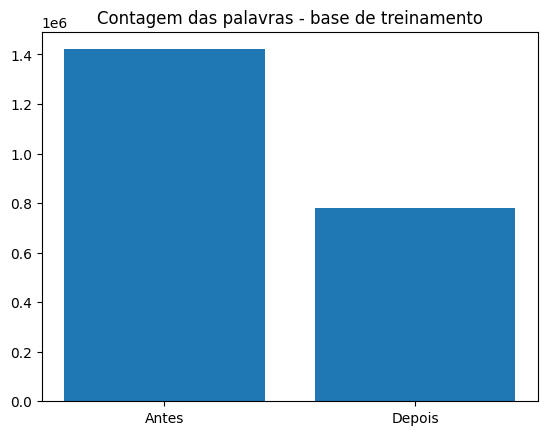

In [333]:
fig, ax = plt.subplots()
ax.bar(['Antes', 'Depois'], [sum(len(filmes_train.loc[i, 'synopsis'].split(' ')) for i in filmes_train.index), sum(len(filmes_train_clean.loc[i, 'synopsis']) for i in filmes_train_clean.index)])
plt.title('Contagem das palavras - base de treinamento')
plt.show()

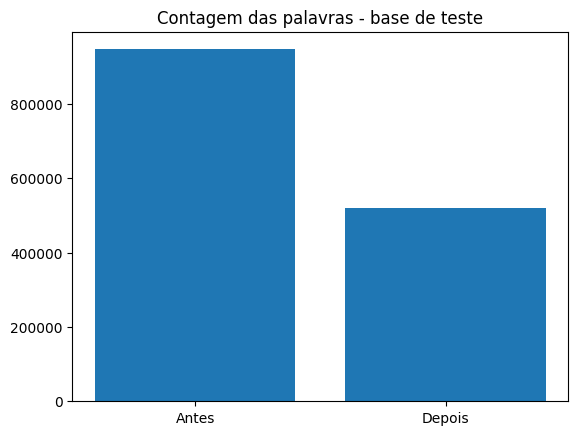

In [334]:
fig, ax = plt.subplots()
ax.bar(['Antes', 'Depois'], [sum(len(filmes_test.loc[i, 'synopsis'].split(' ')) for i in filmes_test.index), sum(len(filmes_test_clean.loc[i, 'synopsis']) for i in filmes_test_clean.index)])
plt.title('Contagem das palavras - base de teste')
plt.show()

# TfidfVectorize

TF-IDF é o produto da Frequência do Termo e da Frequência Inversa do Documento. Trabalha com a frequência das palavras nos documentos, distinguindo as palavras comuns entre todos os documentos, das palavras que pertencem a documentos semelhantes. Comum na área de classificação de texto, passamos de dado em texto/string para numérico.

<p> O cálculo baseia-se na frequência, logo não aprende o contexto e significados baseados em ordem das palavras.

In [335]:
tf_vec = TfidfVectorizer()

Primeiro ajusta o algoritmo nos dados de treinamento e depois transforma os dados de teste baseado nesse ajuste, obtendo a mesma dimensão do dado de treinamento.

In [336]:
data_train = tf_vec.fit_transform(filmes_train_clean.synopsis.str.join(' ')) #lista das sinopses em texto 
label_train = filmes_train_clean.genre.to_list()

In [337]:
data_test = tf_vec.transform(filmes_test_clean.synopsis.str.join(' ')) #lista das sinopses em texto
label_test = filmes_test_clean.genre.to_list() 

# SVM

SVM realiza a classificação dos dados encontrando o hiperplano que melhor diferencia as classes, com margem máxima entre os dados e o hiperplano. Possui dois parâmetros, o tipo de função kernel que irá transformar o problema em linear e o valor positivo de custo C, que pune classificação incorreta. Quanto mais alto o valor de C, maior é a separação emtre as classes. 

<p>Possui um bom desempenho entre os algoritmos de classificação, sua desvantagem é o tempo de processamento.

A função kernel 'poly' foi a que obteve melhor desempenho em menos tempo. C=1 já é seu teto.

In [338]:
svm = SVC(C=1, kernel='poly', random_state=42) 
svm.fit(data_train, label_train)

SVC(C=1, kernel='poly', random_state=42)

In [339]:
predicted = svm.predict(data_train)
accuracy_score(label_train, predicted)

0.8566431604347094

In [340]:
print(classification_report(label_train, predicted))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      5344
           1       0.81      0.82      0.81      5348
           2       0.88      0.89      0.88      5367
           3       0.87      0.87      0.87      5364
           4       0.78      0.83      0.80      5340
           5       0.89      0.88      0.88      5332
           6       0.83      0.84      0.83      5361
           7       0.95      0.92      0.93      5370
           8       0.82      0.85      0.84      5302
           9       0.88      0.84      0.86      5333

    accuracy                           0.86     53461
   macro avg       0.86      0.86      0.86     53461
weighted avg       0.86      0.86      0.86     53461



In [341]:
predicted_test = svm.predict(data_test)
accuracy_score(label_test,predicted_test)

0.09559504758696201

Apresenta bons resultados na base de treinamento, mas tem resultados ruins na base de teste (conceito de overfitting)

# NaiveBayes

Algoritmo baseado na probabilidade condicional de Naive Bayes. Uso do tipo Multinomial, pois é o recomendado para classificação de texto, já que dado será a contagem da frequência (contagem discreta).

In [342]:
nb = MultinomialNB()
nb.fit(data_train, label_train)

MultinomialNB()

In [343]:
accuracy_score(label_train, nb.predict(data_train))

0.5386169357101438

In [344]:
accuracy_score(label_test, nb.predict(data_test))

0.0818944945113563

Apresenta menos de 60% de acurácia no dado de treinamento e possui baixa acurácia na base de teste.

# Dividir melhor a base de dados de treino e de teste

Pode ser que a atual separação não ajuda na aprendizagem do modelo, surtindo um efeito negativo na aprendizagem e na predição. Reunindo as duas bases, vamos propor uma nova divisão aleatória de dados em que 80% serão de dados de treinamento e 20% dados de teste, e então repetir os algoritmos.

In [345]:
data_all = pd.concat([filmes_train_clean, filmes_test_clean])

In [346]:
X_train, X_test, y_train, y_test = train_test_split(data_all.synopsis.str.join(' '), data_all.genre, random_state=42, train_size=0.8, test_size=0.2)

## Refazer o passo do tdif e dos algoritmos

In [347]:
new_data_train = tf_vec.fit_transform(X_train) 
new_data_test = tf_vec.transform(X_test) 

### SVM

In [348]:
new_svm = SVC(C=1, kernel='poly', random_state=42) 
new_svm.fit(new_data_train, y_train.to_list())

SVC(C=1, kernel='poly', random_state=42)

In [349]:
accuracy_score(y_train.to_list(), new_svm.predict(new_data_train))

0.8564632914234396

In [350]:
accuracy_score(y_test.to_list(), new_svm.predict(new_data_test))

0.3863381230354737

### NB

In [351]:
new_nb = MultinomialNB()
new_nb.fit(new_data_train, y_train.to_list())

MultinomialNB()

In [352]:
accuracy_score(y_train.to_list(), new_nb.predict(new_data_train))

0.46141109115401885

In [353]:
accuracy_score(y_test.to_list(), new_nb.predict(new_data_test))

0.45857656039515043

O modelo Naive Bayes acaba tendo uma acurácia mais baixa, porém consegue replicar seus resultados na base de teste dessa vez.

# Salvando os modelos com a biblioteca pickle

In [357]:
pickle.dump(svm, open('svm_filmes.sav', 'wb'))
pickle.dump(nb, open('nb_filmes.sav', 'wb'))
pickle.dump(new_svm, open('new_svm_split_filmes.sav', 'wb'))
pickle.dump(new_nb, open('new_nb_split_filmes.sav', 'wb'))

# Ideias para melhor desempenho

- Aumentar/diversificar a base de treinamento e de teste
- Combinar classes, agrupando temas parecidos 
- Padronização de verbos e nomes
- Revisar mais palavras comuns no texto
- Utilizar métodos de classificação mais complexos: 
    - modelos híbridos
    - modelos pré-treinados
    - rede neural recorrente
    - rede neural convolucional